# Dependencies & Imports

In [ ]:
!pip install pycocotools
!pip install opencv-python
!pip install ultralytics

In [ ]:
import os
import requests
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import cv2
import shutil
import random
from sklearn.model_selection import train_test_split
from ultralytics import YOLO

# Data Preparation

In [ ]:
# Create directories for COCO dataset
os.makedirs('coco', exist_ok=True)

# Download annotations
ann_url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
ann_zip = 'coco/annotations_trainval2017.zip'
if not os.path.exists(ann_zip):
    r = requests.get(ann_url, stream=True)
    with open(ann_zip, 'wb') as f:
        f.write(r.content)

# Extract annotations
!unzip -q coco/annotations_trainval2017.zip -d coco/


loading annotations into memory...
Done (t=22.15s)
creating index...
index created!


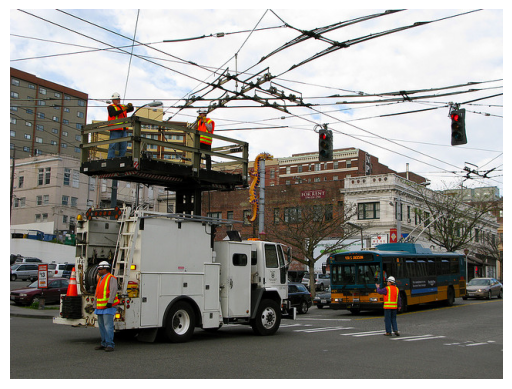

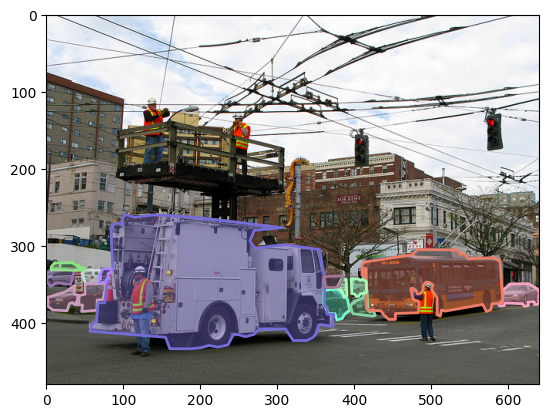

In [ ]:
# Initialize COCO API for instance annotations
coco = COCO('coco/annotations/instances_train2017.json')

category_names = ['car', 'truck', 'bus'] #-->3,6,8
category_ids = coco.getCatIds(catNms=category_names)

# Get all images containing the above categories
image_ids = coco.getImgIds(catIds=category_ids)

# Load image and annotations for a specific image ID
img_id = image_ids[0]
img_info = coco.loadImgs(img_id)[0]
img_path = f"http://images.cocodataset.org/train2017/{img_info['file_name']}"

# Download the image
img_data = requests.get(img_path).content
with open(f"coco/{img_info['file_name']}", 'wb') as handler:
    handler.write(img_data)

# Load and display the image
img = cv2.imread(f"coco/{img_info['file_name']}")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Load annotations for the image
ann_ids = coco.getAnnIds(imgIds=img_info['id'], catIds=category_ids, iscrowd=None)
anns = coco.loadAnns(ann_ids)

# Display annotations
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
coco.showAnns(anns)


In [ ]:
def prepare_annotations(annotations):
   """
    Prepare annotation data by extracting bounding box and category information
    and mapping category IDs to the appropriate YOLO model categories.

    Args:
        annotations (list of dict): A list of annotations, where each annotation
        is a dictionary containing 'bbox' (bounding box coordinates) and
        'category_id' (class identifier) fields.

    Returns:
        dict: A dictionary with two keys:
            - 'bbox': A list of bounding box coordinates from the annotations.
            - 'category_id': A list of category IDs, potentially mapped to YOLO's expected category IDs.
    """
    entry = {"bbox": [], "category_id": []}
    Yolo_mapping = {3: 2, 6: 5, 8: 7}

    for annotation in annotations:
        entry["bbox"].append(annotation["bbox"])
        mapped_category_id = Yolo_mapping.get(annotation["category_id"], annotation["category_id"])
        entry["category_id"].append(mapped_category_id)
    return entry

## Getting all data with annotations

In [ ]:
# Initialize lists to store images and annotations
train_images = []
train_images_paths = []
train_annotations = []

for img_id in image_ids:
    img_info = coco.loadImgs(img_id)[0]
    img_filename = img_info['file_name']
    img_path = os.path.join('coco', img_filename)

    # Download and save the image locally
    img_url = f"http://images.cocodataset.org/train2017/{img_filename}"
    img_data = requests.get(img_url).content
    with open(img_path, 'wb') as handler:
        handler.write(img_data)

    # Load image using OpenCV
    img = cv2.imread(img_path)

    # Load annotations
    ann_ids = coco.getAnnIds(imgIds=img_info['id'], catIds=category_ids, iscrowd=None)
    anns = coco.loadAnns(ann_ids)

    # Append the image, local path, and annotations to the lists
    train_images.append(img)
    train_images_paths.append(img_path)
    train_annotations.append(prepare_annotations(anns))

In [ ]:
def convert_to_yolo_format(img_width, img_height, annotations):
    """
    Convert bounding box annotations to the YOLO format, where the bounding boxes
    are normalized relative to the image dimensions. The YOLO format expects each
    annotation to consist of:

    <category_id> <x_center> <y_center> <width> <height>

    where the coordinates and dimensions are normalized to the image width and height.

    Args:
        img_width (int): The width of the image.
        img_height (int): The height of the image.
        annotations (dict): A dictionary containing:
            - 'bbox' (list of lists): A list of bounding box coordinates in the format
              [x_min, y_min, box_width, box_height].
            - 'category_id' (list of int): A list of category IDs corresponding to each bounding box.

    Returns:
        list of str: A list of YOLO-formatted annotations, where each string represents
        a single object annotation in the format:
        "<category_id> <x_center> <y_center> <width> <height>"
    """

    yolo_annotations = []

    for bbox, category_id in zip(annotations['bbox'], annotations['category_id']):
        # Extract the bounding box coordinates
        x_min, y_min, box_width, box_height = bbox

        # Convert to YOLO format (normalize to image dimensions)
        x_center = (x_min + box_width / 2) / img_width
        y_center = (y_min + box_height / 2) / img_height
        width = box_width / img_width
        height = box_height / img_height

        # Append the annotation in YOLO format
        yolo_annotations.append(f"{category_id} {x_center} {y_center} {width} {height}")

    return yolo_annotations


In [ ]:
Yolo_annotations = []

for index in range(len(train_images)):
    img_height, img_width, _ = train_images[index].shape

    # Convert to YOLO format
    yolo_format = convert_to_yolo_format(img_width, img_height, train_annotations[index])

    # Append to the list of YOLO annotations
    Yolo_annotations.append(yolo_format)


## Preparing data hierarchy

In [ ]:
base_dir = 'data'

subdirs = ['images/train', 'images/val', 'images/test',
           'labels/train', 'labels/val', 'labels/test']

for subdir in subdirs:
    path = os.path.join(base_dir, subdir)
    os.makedirs(path, exist_ok=True)

print(f"Directory structure created under '{base_dir}'")


Directory structure created under 'data'


## Transfer images to data directory

In [ ]:
# Paths to your original image and annotation directories
original_images_dir = 'coco/images/'
output_images_train_dir = 'data/images/train/'
output_images_val_dir = 'data/images/val/'
output_labels_train_dir = 'data/labels/train/'
output_labels_val_dir = 'data/labels/val/'

# Create directories if they don't exist
os.makedirs(output_images_train_dir, exist_ok=True)
os.makedirs(output_images_val_dir, exist_ok=True)
os.makedirs(output_labels_train_dir, exist_ok=True)
os.makedirs(output_labels_val_dir, exist_ok=True)

# Assuming Yolo_annotations is a list of YOLO formatted annotations
# and train_images_paths is a list of corresponding image file paths

# Split the data into training and validation sets
train_annotations, val_annotations, train_images, val_images = train_test_split(
    Yolo_annotations, train_images_paths, test_size=0.2, random_state=42
)

# Function to move images and save annotations
def save_annotations_and_images(images, annotations, images_dir, labels_dir):
    for img_path, yolo_annotation in zip(images, annotations):
        # Get the image file name without extension
        image_name = os.path.basename(img_path)
        image_base_name = os.path.splitext(image_name)[0]

        # Define paths
        destination_image_path = os.path.join(images_dir, image_name)
        annotation_file_path = os.path.join(labels_dir, f"{image_base_name}.txt")

        # Move/copy the image
        shutil.move(img_path, destination_image_path)

        # Save the annotation as a .txt file
        with open(annotation_file_path, 'w') as f:
            f.write('\n'.join(yolo_annotation))

# Save training data
save_annotations_and_images(train_images, train_annotations, output_images_train_dir, output_labels_train_dir)

# Save validation data
save_annotations_and_images(val_images, val_annotations, output_images_val_dir, output_labels_val_dir)

print("Data splitting, image moving, and annotation saving completed successfully!")


Data splitting, image moving, and annotation saving completed successfully!


# Training

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

model.train(data='/content/data.yaml', epochs=3, imgsz=640)

100%|██████████| 6.25M/6.25M [00:00<00:00, 22.6MB/s]


Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, 

100%|██████████| 755k/755k [00:00<00:00, 4.35MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

train: Scanning /content/data/labels/train... 516 images, 0 backgrounds, 0 corrupt: 100%|██████████| 516/516 [00:00<00:00, 1730.95it/s]


train: WARNING ⚠️ /content/data/images/train/000000099844.jpg: 2 duplicate labels removed
train: New cache created: /content/data/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/data/labels/val... 130 images, 0 backgrounds, 0 corrupt: 100%|██████████| 130/130 [00:00<00:00, 1841.84it/s]

val: New cache created: /content/data/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G      1.276       2.55      1.207         76        640: 100%|██████████| 33/33 [07:59<00:00, 14.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:37<00:00,  7.58s/it]

                   all        130       1064      0.565      0.595      0.578      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3         0G      1.221      1.446      1.163         59        640: 100%|██████████| 33/33 [07:34<00:00, 13.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:34<00:00,  6.93s/it]

                   all        130       1064      0.609      0.548      0.586      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3         0G      1.224      1.331      1.145         38        640: 100%|██████████| 33/33 [07:34<00:00, 13.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:36<00:00,  7.23s/it]

                   all        130       1064      0.595      0.564      0.589      0.414



3 epochs completed in 0.420 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:33<00:00,  6.73s/it]


                   all        130       1064      0.595      0.565      0.589      0.414
                   car        130        608      0.622      0.541      0.583      0.357
                   bus        130        220      0.665      0.694      0.727      0.557
                 truck        130        236      0.497      0.461      0.458      0.327
Speed: 2.7ms preprocess, 204.3ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([2, 5, 7])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79290cc5c0d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

# Testing

In [ ]:
classes = [2, 5, 7] # Car, Truck, Bus
conf_thresh = 0.5

source = "/content/data/images/test/"

results = model.predict(source=source, save=True, classes=classes, conf=conf_thresh)


image 1/1 /content/data/images/test/urban-street-scene-vienna-austria-DD1XEP.jpg: 480x640 3 cars, 1 bus, 292.9ms
Speed: 6.9ms preprocess, 292.9ms inference, 41.8ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/train2


# Optimization

In [ ]:
model.train(
    data='/content/data.yaml',       # Path to your YAML configuration file
    epochs=10,                       # Number of epochs
    imgsz=640,                       # Image size
    lr0=0.001,                       # Initial learning rate
    lrf=0.1,                         # Learning rate schedule factor
    optimizer='AdamW',               # Optimizer
    half=True,                       # Use mixed precision training if GPU supports it
    rect=True,                       # Rectangular training mode
    plots=True                       # Save training plots
)


Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=True, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=True, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True,

train: Scanning /content/data/labels/train.cache... 516 images, 0 backgrounds, 0 corrupt: 100%|██████████| 516/516 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/data/images/train/000000099844.jpg: 2 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
WARNING ⚠️ 'rect=True' is incompatible with DataLoader shuffle, setting shuffle=False



val: Scanning /content/data/labels/val.cache... 130 images, 0 backgrounds, 0 corrupt: 100%|██████████| 130/130 [00:00<?, ?it/s]

Plotting labels to runs/detect/train3/labels.jpg... 


optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      2.451      4.661      1.964         26        448: 100%|██████████| 33/33 [05:47<00:00, 10.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:48<00:00,  9.65s/it]

                   all        130       1064      0.278     0.0102      0.146     0.0789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.899      3.477      1.544         26        448: 100%|██████████| 33/33 [05:58<00:00, 10.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:46<00:00,  9.28s/it]

                   all        130       1064      0.192       0.26      0.182      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.818       2.63      1.506         29        448: 100%|██████████| 33/33 [05:53<00:00, 10.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:47<00:00,  9.57s/it]

                   all        130       1064      0.343      0.332      0.236      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.713      2.409       1.43         24        448: 100%|██████████| 33/33 [05:44<00:00, 10.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:45<00:00,  9.16s/it]

                   all        130       1064      0.342      0.376      0.284      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.617      2.165      1.373         29        448: 100%|██████████| 33/33 [05:46<00:00, 10.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:45<00:00,  9.06s/it]

                   all        130       1064      0.386      0.435      0.377      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.519      2.002      1.322         27        448: 100%|██████████| 33/33 [05:37<00:00, 10.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:42<00:00,  8.52s/it]

                   all        130       1064      0.436      0.418      0.376      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.475      1.913      1.307         28        448: 100%|██████████| 33/33 [05:31<00:00, 10.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:42<00:00,  8.59s/it]

                   all        130       1064      0.461      0.427      0.403      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.466      1.852      1.287         29        448: 100%|██████████| 33/33 [05:30<00:00, 10.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:43<00:00,  8.64s/it]

                   all        130       1064       0.45      0.441      0.423      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G       1.43      1.812      1.278         26        448: 100%|██████████| 33/33 [05:31<00:00, 10.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:47<00:00,  9.44s/it]

                   all        130       1064      0.446      0.444      0.435      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.381      1.754       1.25         29        448: 100%|██████████| 33/33 [05:33<00:00, 10.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:40<00:00,  8.15s/it]

                   all        130       1064      0.465      0.442      0.447      0.295



10 epochs completed in 1.082 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:37<00:00,  7.46s/it]


                   all        130       1064      0.466      0.445      0.447      0.295
                   car        130        608      0.473      0.451      0.446      0.266
                   bus        130        220      0.537      0.532      0.563      0.401
                 truck        130        236      0.388      0.352      0.331      0.219
Speed: 7.2ms preprocess, 229.3ms inference, 0.0ms loss, 10.4ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([2, 5, 7])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79290e412dd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04